In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [8, 6]

import scipy.stats as stats

import statsmodels.formula.api as sfa

In [2]:
train = pd.read_csv("~/Downloads/Bigmart_Train (1).csv")
test = pd.read_csv("~/Downloads/Bigmart_Test (1).csv")

In [15]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [3]:
# Outlet Size
dict_size = {"Medium":3, "High":2, "Small":1}
train["Outlet_Size"]= train.Outlet_Size.map(dict_size)
test["Outlet_Size"]= test.Outlet_Size.map(dict_size)

In [4]:
# Applying pd.get_dummies
dummytrain = pd.get_dummies(train, drop_first = True)
dummytest = pd.get_dummies(test, drop_first = True)

In [5]:
dummytrain.shape, dummytest.shape

((8523, 18), (5681, 17))

### Modeling

* Linear Regression
* Interaction Model
* Model Based on Feature Selection

In [11]:
# Full Model ~ Linear Regression


# Import the Linear Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Fit & Predict
pred = lr.fit(X, y).predict(dummytest)

In [7]:
# Cross Validation....
from sklearn.model_selection import KFold
X = dummytrain.drop("Item_Outlet_Sales", axis = 1)
y = dummytrain.Item_Outlet_Sales

In [32]:
# Build the Model using K Fold Cross Validation
meri_x = KFold(n_splits = 5, shuffle = True)

# Model
from sklearn.linear_model import LinearRegression, SGDRegressor
lr = LinearRegression()
sgd = SGDRegressor()

my_list=[]
for train_index, test_index in meri_x.split(X, y):
    xtrain = X.loc[train_index]
    ytrain = y.loc[train_index]
    xtest = X.loc[test_index]
    ytest = y.loc[test_index]
    my_list.append(gbm.fit(xtrain, ytrain).predict(xtest))

In [33]:
finalpred = pd.DataFrame(my_list).T.mean(axis = 1)

In [34]:
# Check the Metrics
from sklearn.metrics import r2_score, mean_squared_error
print("R2 Score: ", r2_score(ytest, finalpred[1:]))
print("RMSE: ", np.sqrt(mean_squared_error(ytest, finalpred[1:])))

R2 Score:  -0.17771690116997685
RMSE:  1761.308878107113


In [35]:
# Cross Validation For Submission
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)

lr = LinearRegression()
my_list = []

for train_index, test_index in kfold.split(X, y):
    xtrain = X.loc[train_index]
    ytrain = y.loc[train_index]
    my_list.append(lr.fit(xtrain, ytrain).predict(dummytest))

### About Cross Validation

* It is a kind of a model which uses multiple samples to learn the pattern from the data and then predicts on the test set.

* Here, the samples drawn are divided in n folds. The data is then bifurcated basis the folds and the learning happens on each and every fold followed by the prediction.

* Cross Validation models are more reliable than a general train test split because it helps cut down the Variance in the Prediction

#### About LOOCV
* Leave One Out Cross Validation is an approach where the model is learning on each row and  predicting on each row. 

* Thus, it is very different from the Cross Validation approach where the KFolds represent K Samples of Data taken to build the Same Model.

* LOOCV can work well with smaller datasets where as It would become Computationally very expensive as each row is used for fitting and predicting.

**Note: As the number of folds increase, overfitting begins. The popular split value is 5, 10, 20, 25, 50...50 is used in the extreme scenarios.**

In [40]:
finalpred = np.abs(pd.DataFrame(my_list).T.mean(axis = 1))

In [41]:
# Import the Submission file
submission = pd.read_csv("~/Downloads/sample_submission_8RXa3c6 (1).csv")

In [42]:
submission["Item_Outlet_Sales"] = finalpred

In [21]:
submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1805.784280
1,FDW14,OUT017,1624.002777
2,NCN55,OUT010,1875.051884
3,FDQ58,OUT017,2627.525744
4,FDY38,OUT027,5193.309001


In [24]:
# Export the Submission File
submission.to_csv("LRMODEL.csv", index = False) # 1191.8904113188273

In [23]:
cd

C:\Users\IT


In [25]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [26]:
sfs = SequentialFeatureSelector(estimator = lr,
                                k_features="best",
                               forward = True,
                               scoring = "neg_mean_squared_error")

In [27]:
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(1, 17),
                          scoring='neg_mean_squared_error')

In [32]:
# Extracted the Dataset basis New Features...
sfs_feats = X.loc[:, sfs.k_feature_names_]
test_feats = dummytest.loc[:, sfs.k_feature_names_]

In [33]:
# Build the Model
pred_sfs = lr.fit(sfs_feats, y).predict(test_feats)

In [34]:
submission["Item_Outlet_Sales"] = np.abs(pred_sfs)

In [38]:
submission.to_csv("SFSMODEL.csv", index = False) # 1192.73

In [40]:
sfs_feats.columns

Index(['Item_MRP', 'Outlet_Size', 'Item_Fat_Content_Regular',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3',
       'Outlet_Perf_Low_Perf'],
      dtype='object')

#### Regularization

In [43]:
lr = LinearRegression()

In [44]:
lr.fit(X, y) # Fit the Model...

LinearRegression()

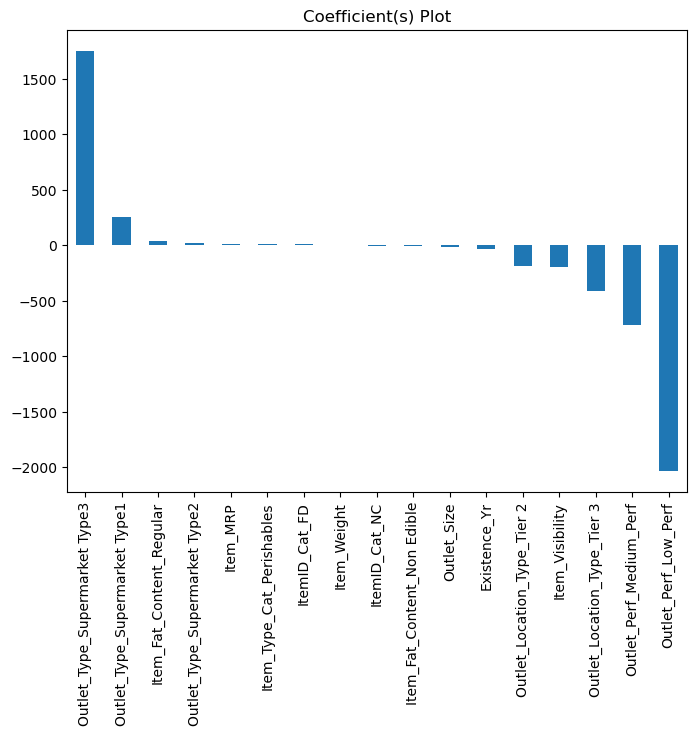

In [49]:
pd.Series(lr.coef_, 
          index = X.columns).sort_values(ascending = False)\
.plot(kind = "bar")
plt.title("Coefficient(s) Plot")
plt.show()# Params

In [55]:
from sklearn.linear_model import Ridge, Lasso
ridge = Ridge(alpha = 25, normalize = True) # lambda ~ alpha
ridge.fit(X, y)

Lasso(alpha=0.5, normalize=True)

In [ ]:
lasso = Lasso(alpha = 0.25, normalize = True)
lasso.fit(X, y)

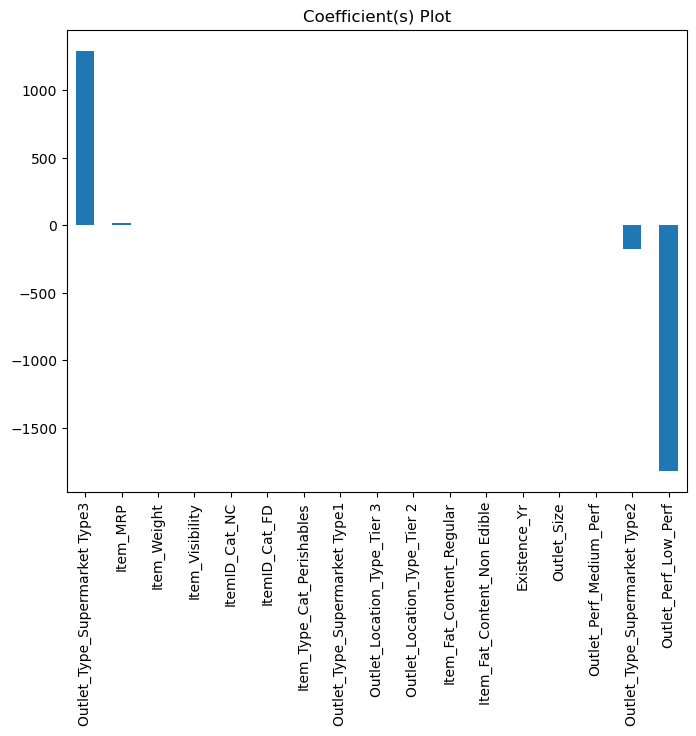

In [56]:
pd.Series(lasso.coef_, 
          index = X.columns).sort_values(ascending = False)\
.plot(kind = "bar")
plt.title("Coefficient(s) Plot")
plt.show()# Params

In [57]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

rf.fit(X, y)

RandomForestRegressor()

<AxesSubplot:>

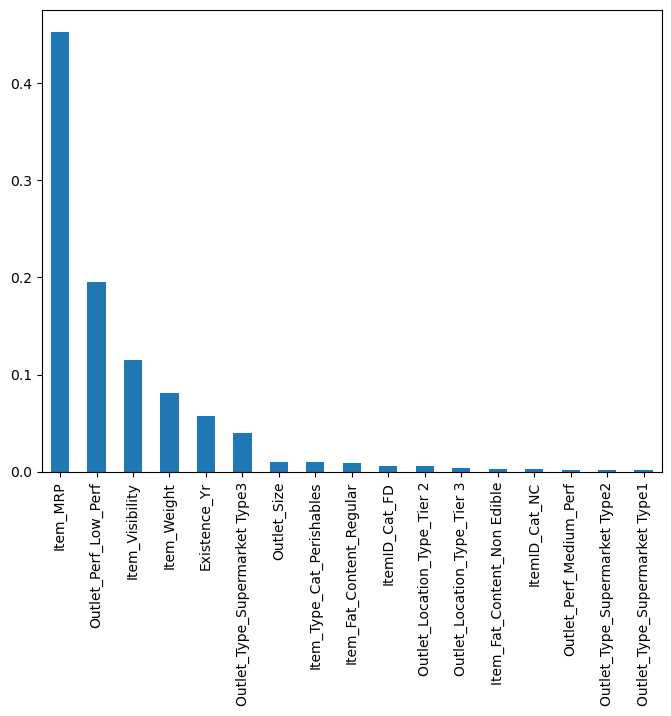

In [60]:
pd.Series(rf.feature_importances_, index =X.columns).\
sort_values(ascending=False).plot(kind = "bar")

In [61]:
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)

pred = []
for train_index, test_index in kfold.split(X, y):
    xtrain = X.loc[train_index]
    ytrain = y.loc[train_index]
    pred.append(rf.fit(xtrain, ytrain).predict(dummytest))

In [62]:
vals = pd.DataFrame(pred).T.mean(axis = 1)
submission["Item_Outlet_Sales"] = np.abs(vals)

In [64]:
submission.to_csv("RandomForest.csv", index = False) #1185

In [65]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha = 0.5, l1_ratio=0.01)

<AxesSubplot:>

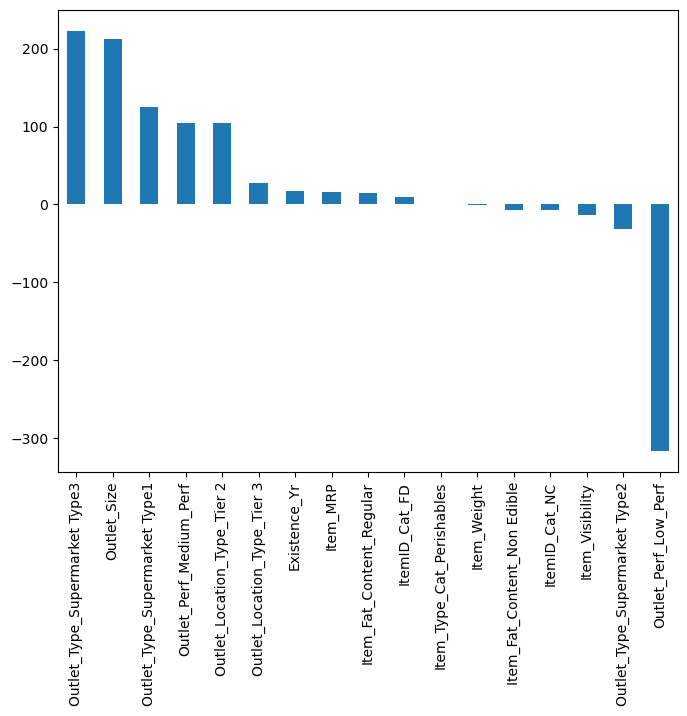

In [68]:
enet.fit(X, y)

pd.Series(enet.coef_, X.columns).sort_values(ascending = False)\
.plot(kind = "bar")